# SpArch spMspM accelerator

First, include some libraries

In [2]:
# Run boilerplate code to set up environment

%run ../prelude.py

interactive(children=(Dropdown(description='style', options=('tree', 'uncompressed', 'tree+uncompressed'), val…

Button(description='Run all cells below', style=ButtonStyle())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Read matrices


Input A


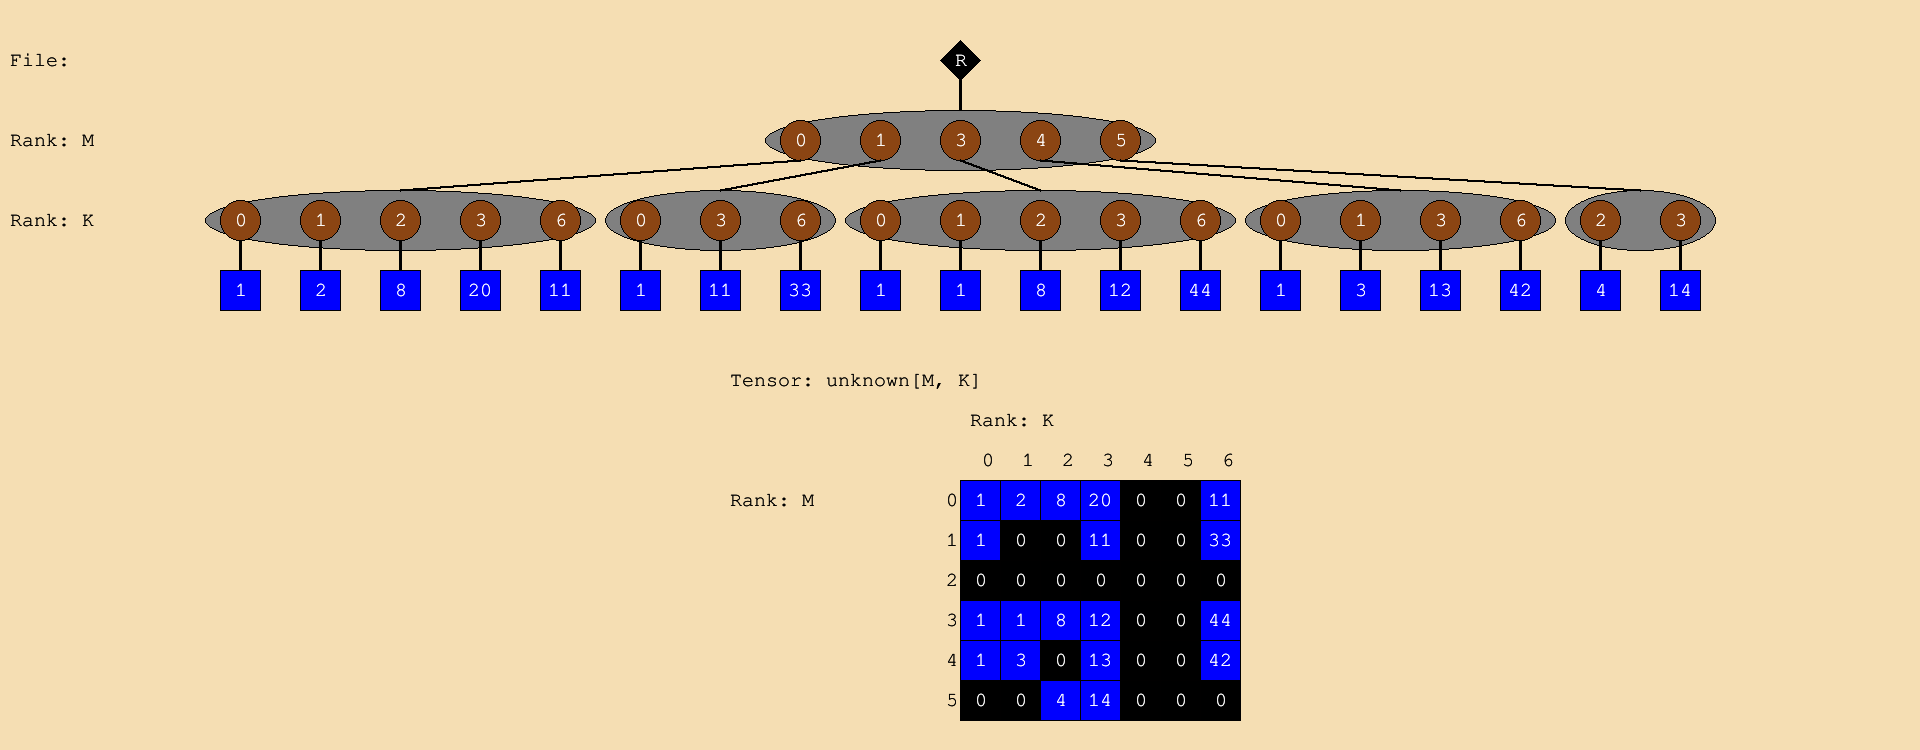

Input A - swapped


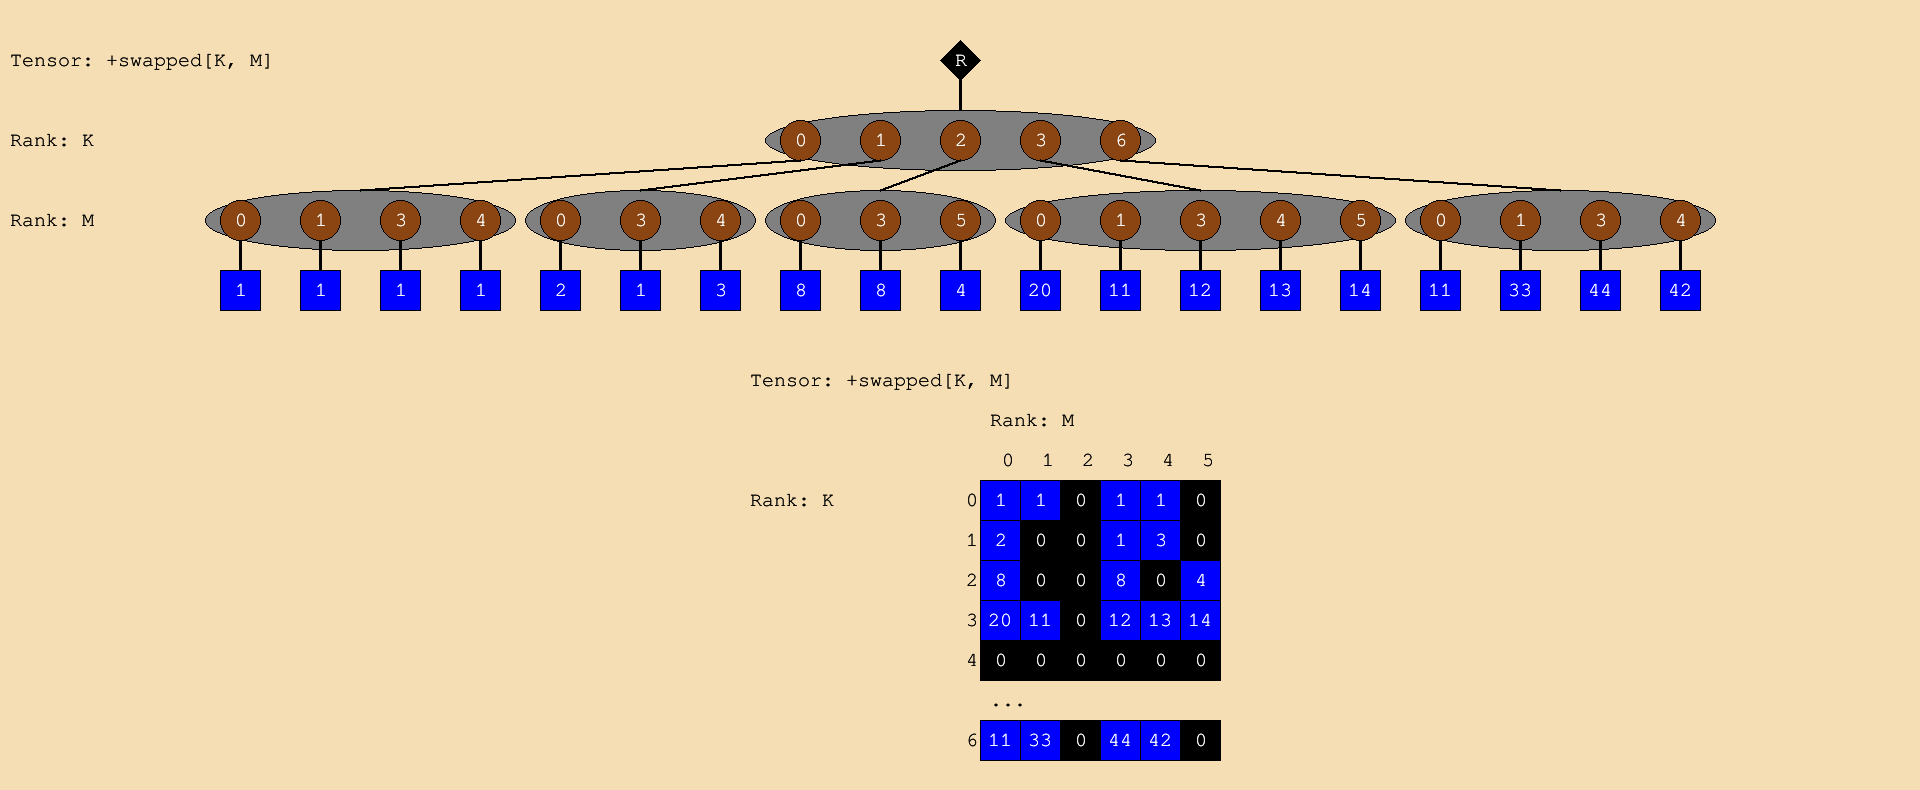

Input B


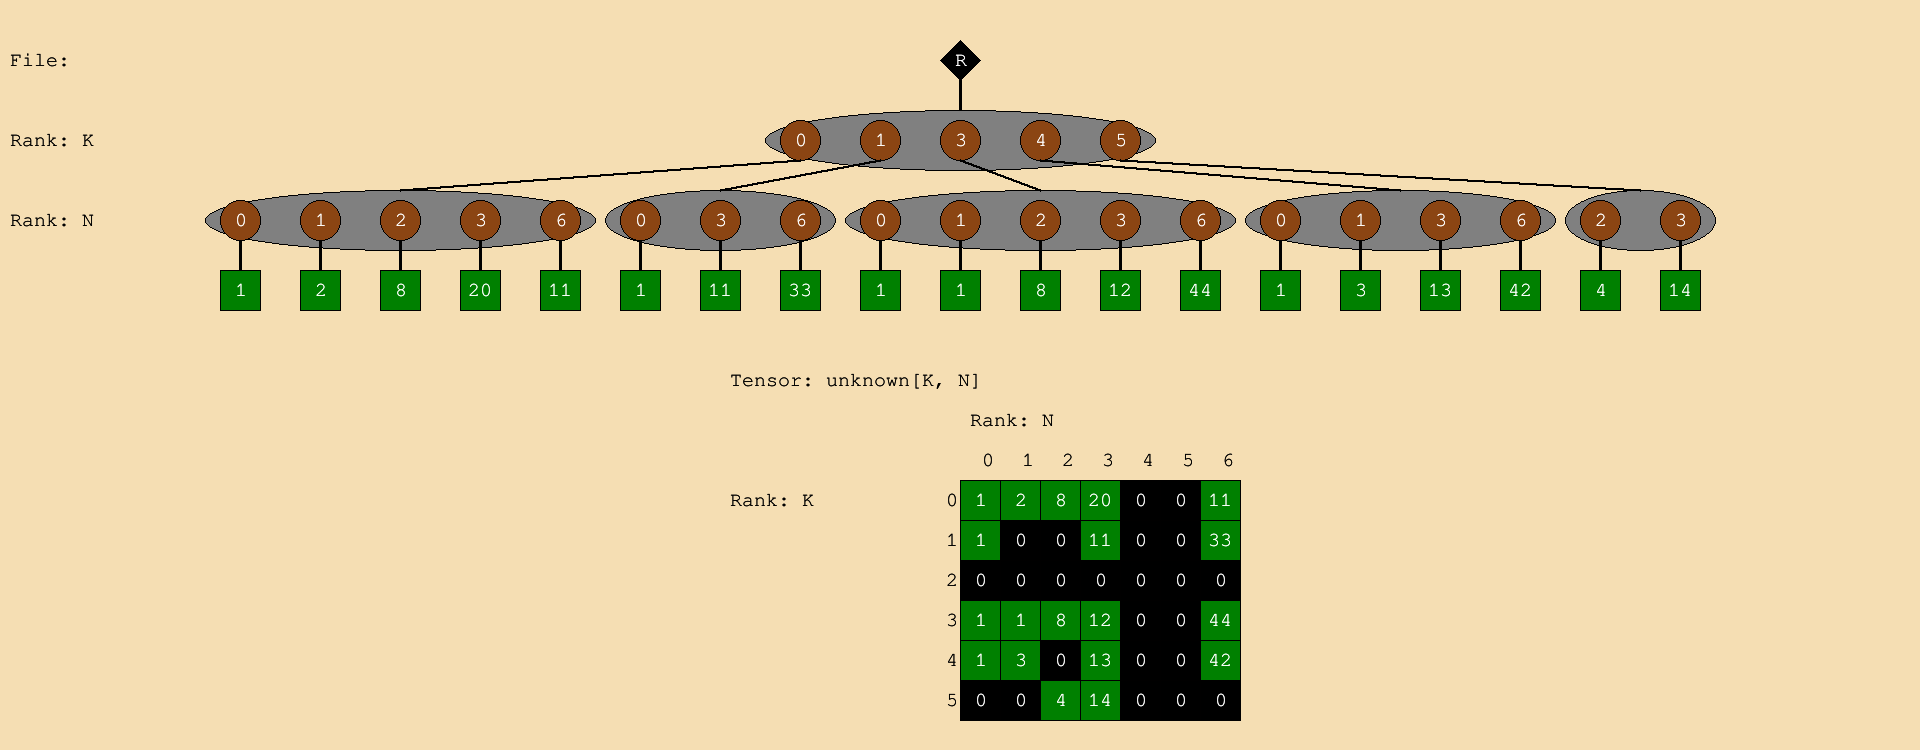

Result Z (precomputed)


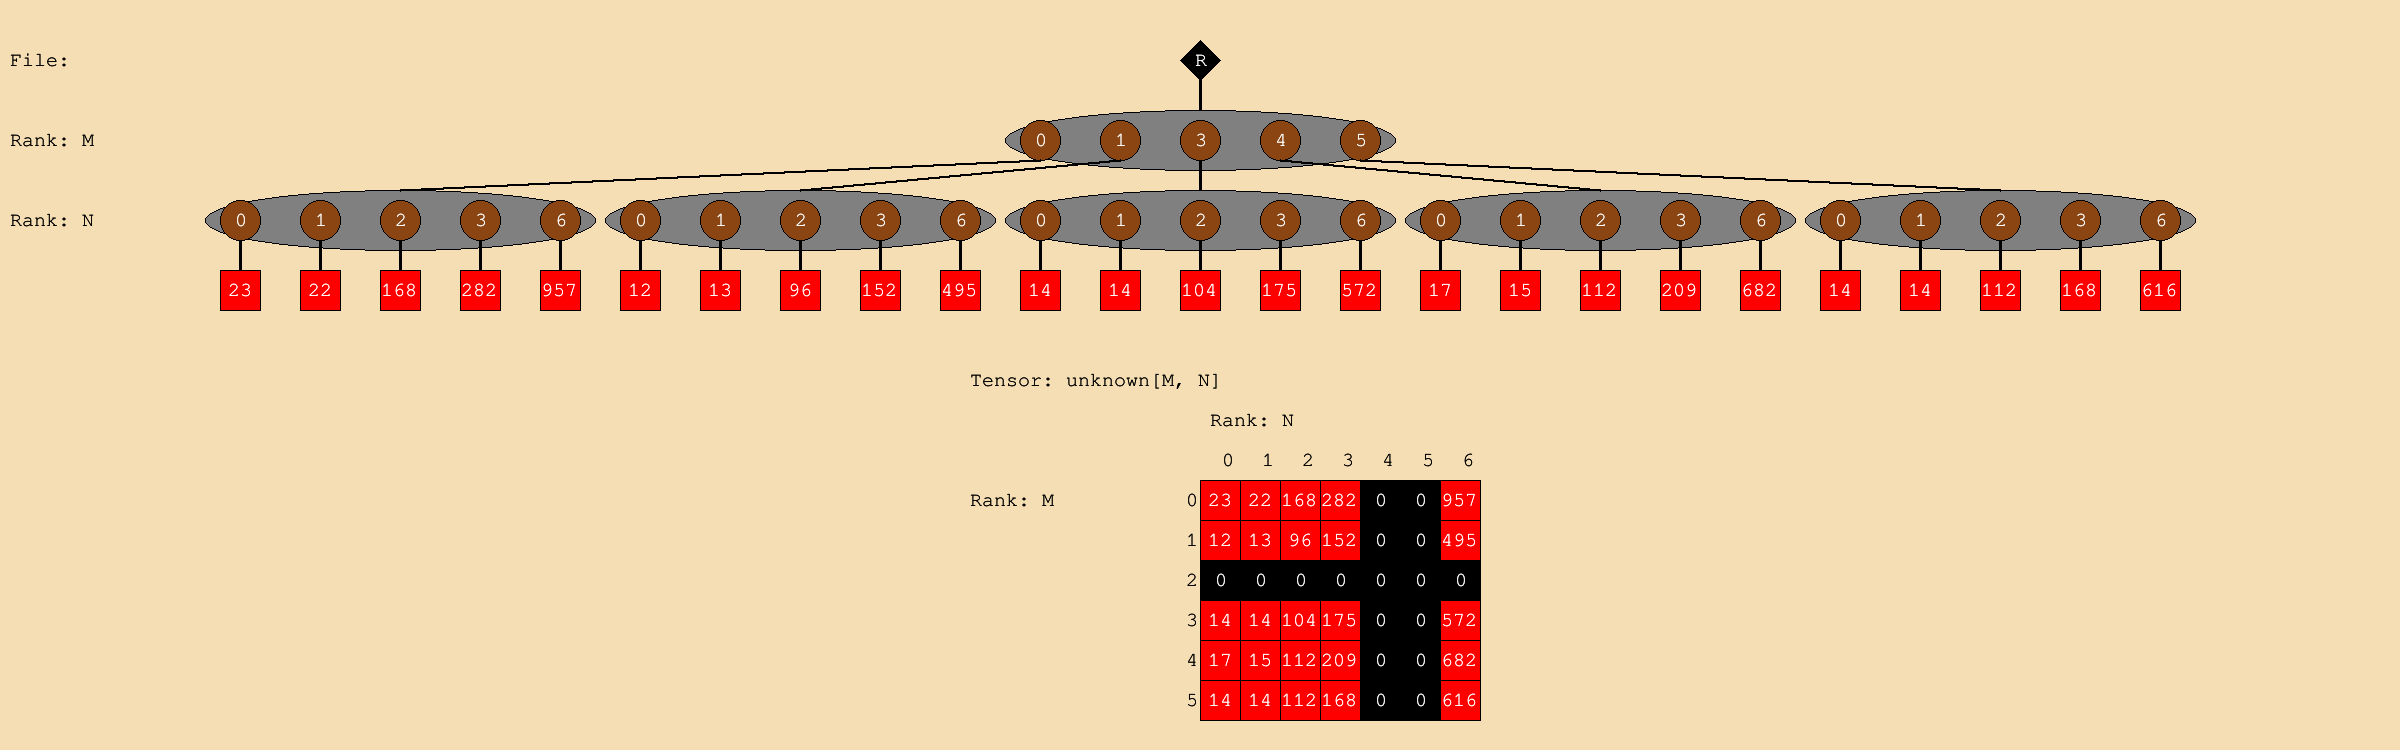

In [31]:
import os

os.environ['FIBERTREE_FONT'] = '/Library/Fonts/FreeMono.ttf'

a = Tensor.fromYAMLfile(os.path.join(data_dir, "sparse-matrix-a.yaml"))
b = Tensor.fromYAMLfile(os.path.join(data_dir, "sparse-matrix-b.yaml"))

# Swap ranks of the "a" matrix as desired by the outer product traveral order
at = a.swapRanks()

print("Input A")
displayTensor(a.setColor("blue"))

print("Input A - swapped")
displayTensor(at.setColor("blue"))

print("Input B")
displayTensor(b.setColor("green"))
    
z_verify = Tensor.fromYAMLfile(os.path.join(data_dir, "sparse-matrix-a_times_b.yaml"))

print("Result Z (precomputed)")
displayTensor(z_verify)

## SpArch - Create Input

Input A


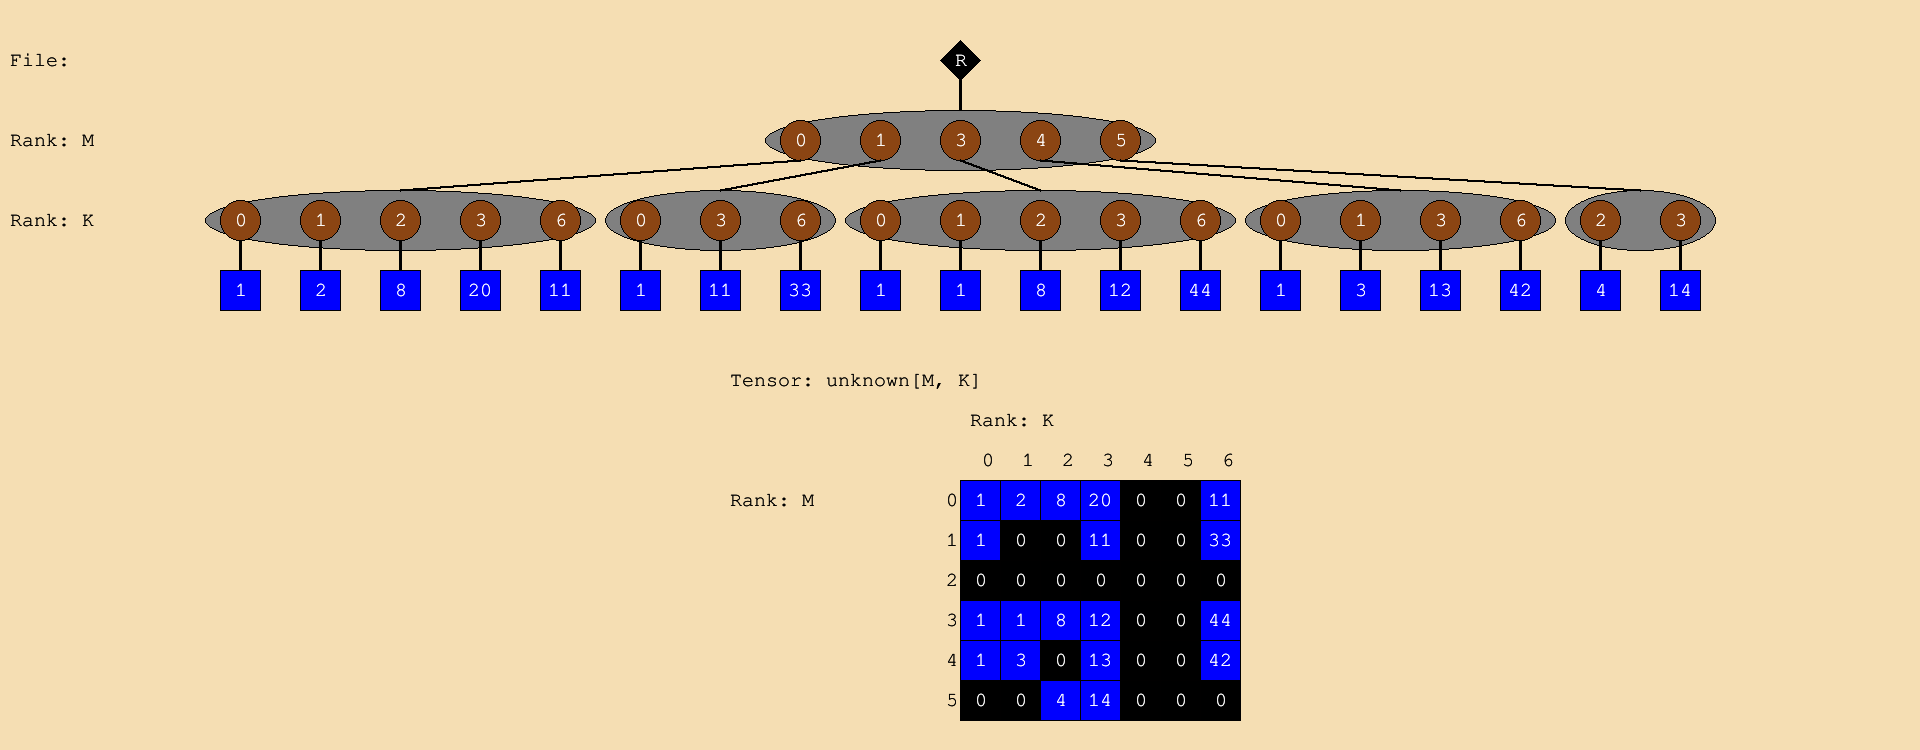

Input A -- split


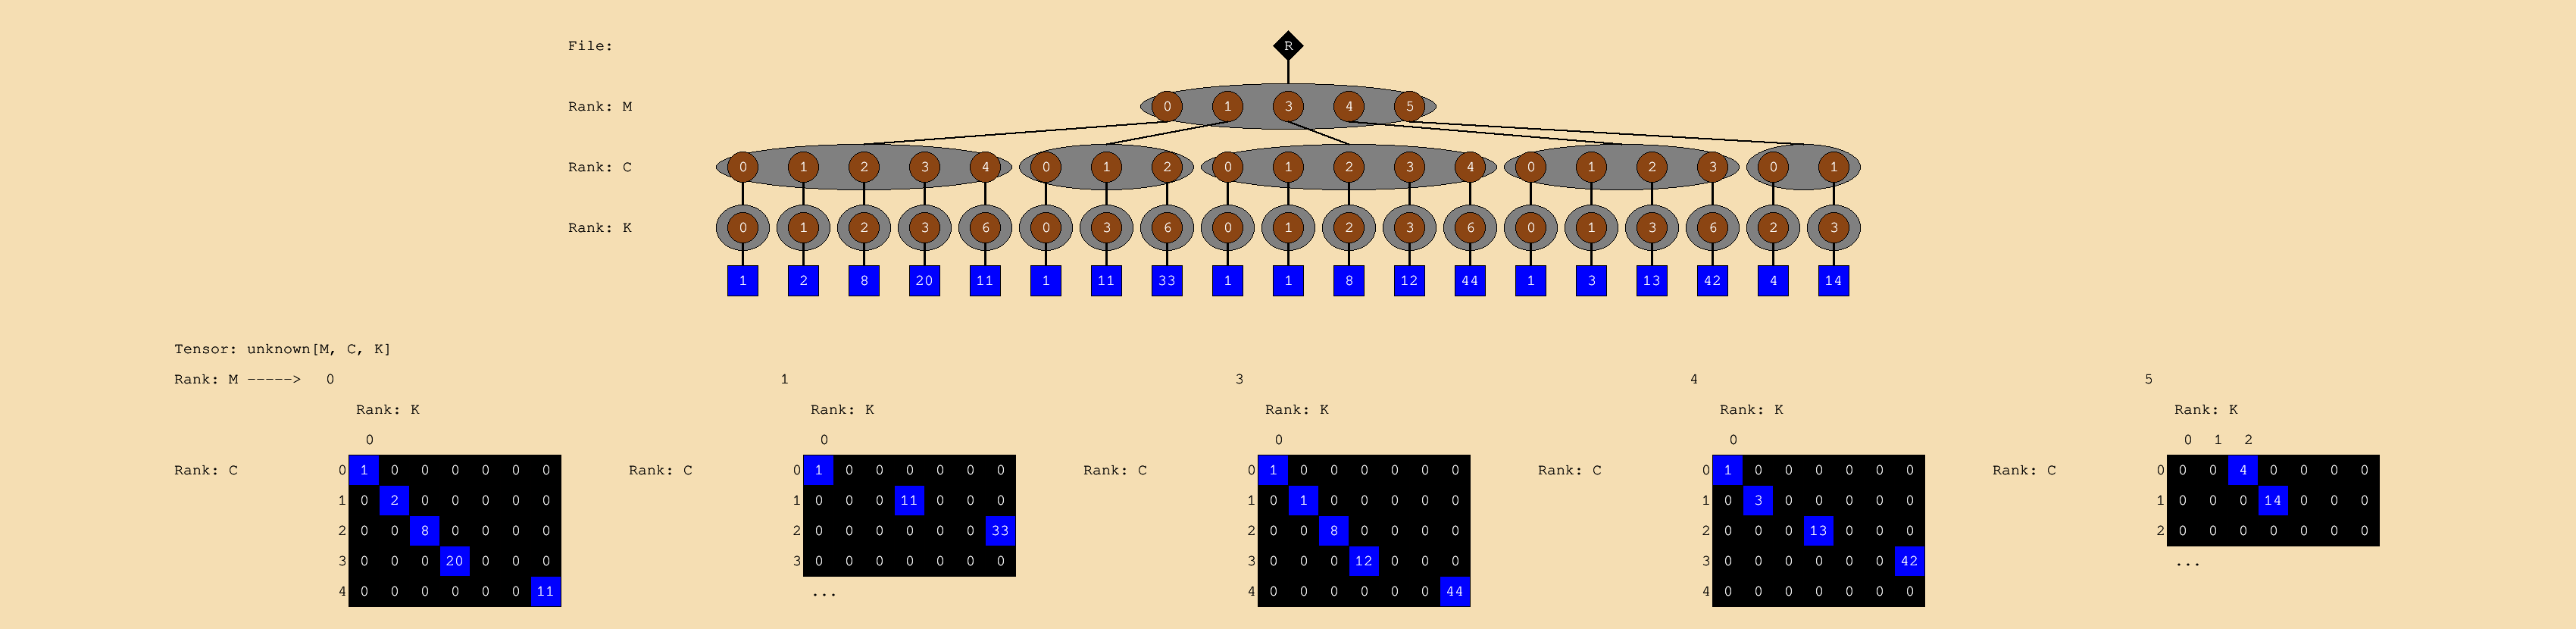

Input A -- split and transposed


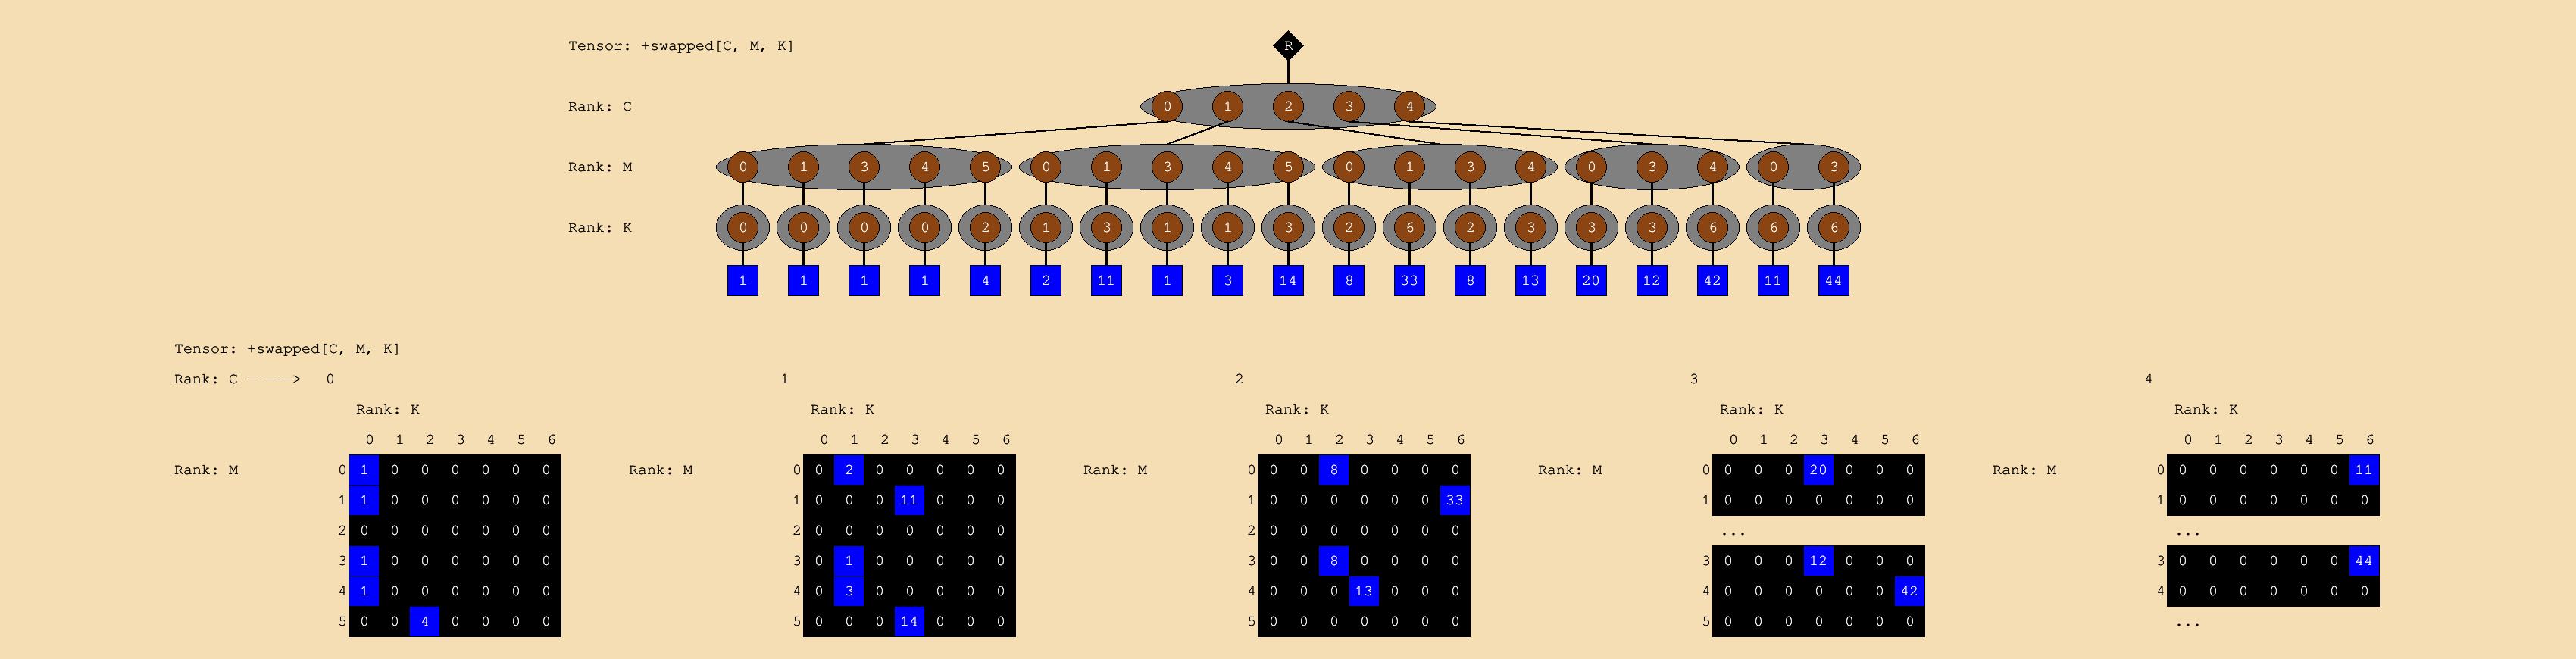

In [32]:

print("Input A")
displayTensor(a)


# Step 1: split A by adding a middle rank C
# This middle rank C has a one-to-one mapping to its lower rank (K)
# Rank C uses a coordinate that used to be the position in rank K of A
# This coincides with the old naming convention in fiber.py!

ac = Tensor(rank_ids=["M", "C", "K"])
ac.setColor("blue")

a_m = a.getRoot()
ac_m = ac.getRoot()

for m, (ac_c, a_k) in ac_m << a_m:
    # Use the old naming style!
    # The new rank is named after the position (i.e., count)
    
    ac_c += a_k.splitEqual(1)
    ac_c.updateCoords(lambda i, c, p: i)

# Now ac is["M", "C", "K"]
print("Input A -- split")
displayTensor(ac)

# Step 2: swap the M and C rank of AC

act = ac.swapRanks() # swap rank M and C
act.setColor("blue")

# Now act is ["C", "M", "K"]
print("Input A -- split and transposed")
displayTensor(act)

## SpArch - Do multiply

Result Z (computed)


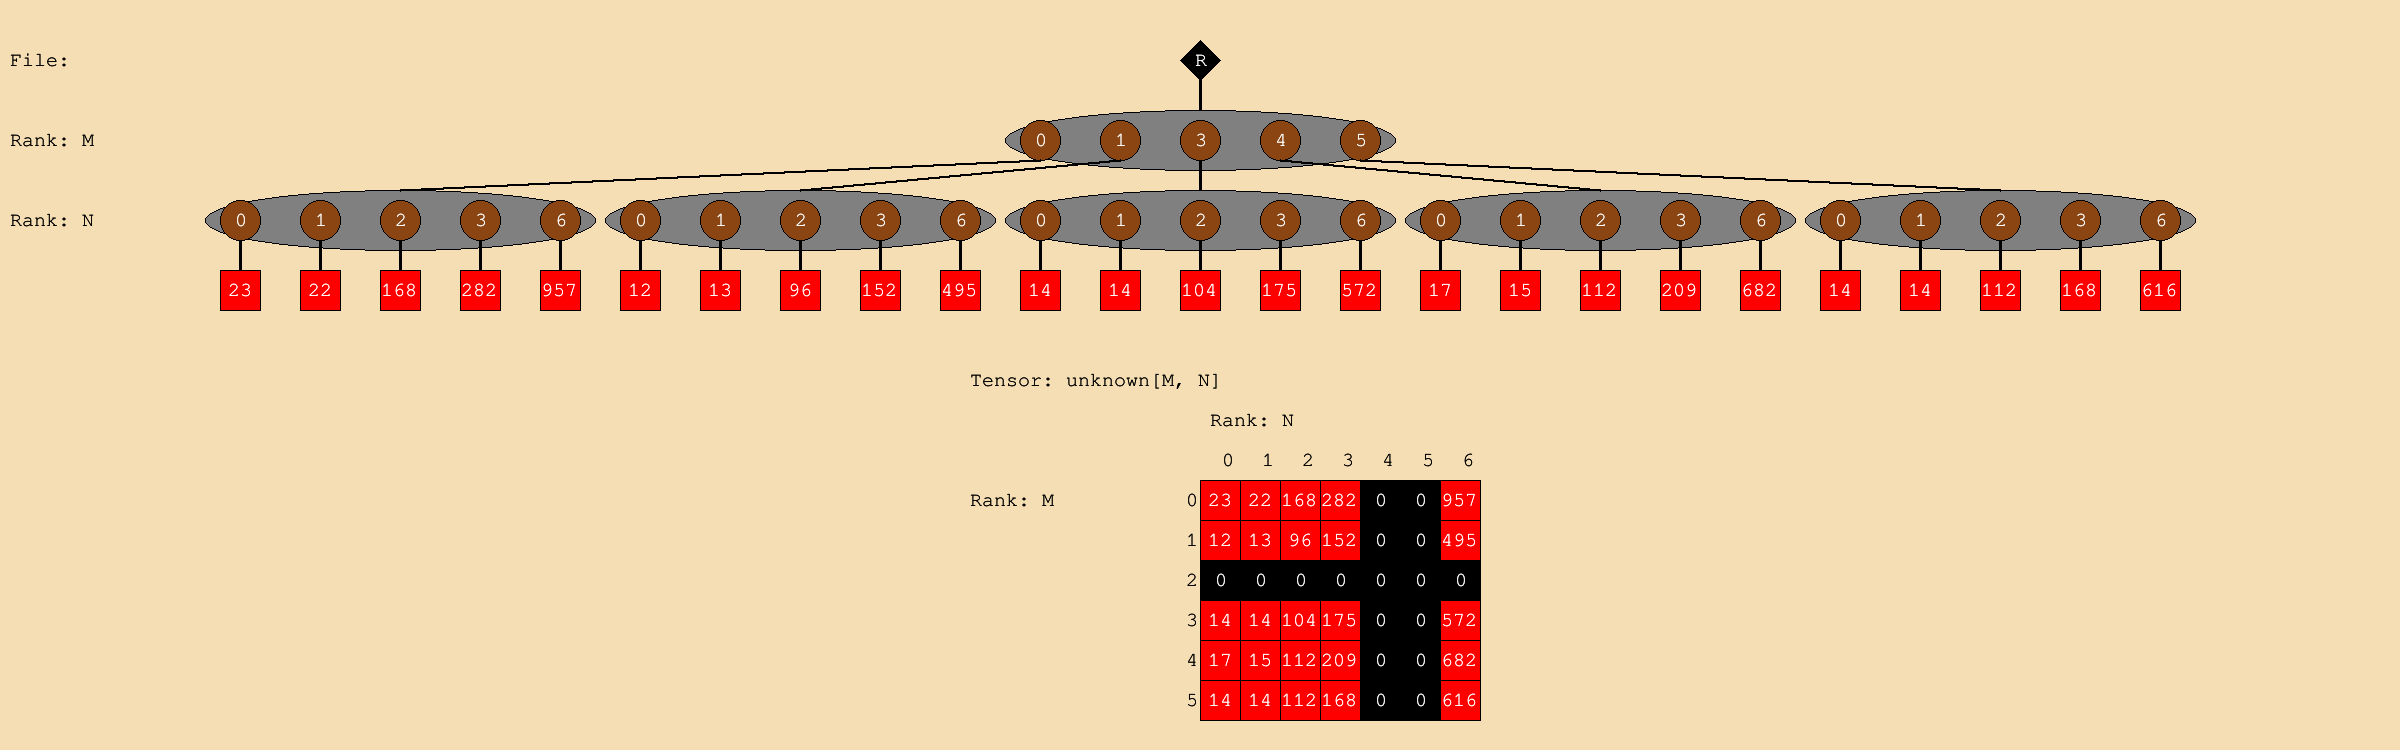

  0%|          | 0/56 [00:00<?, ?it/s]

In [ ]:
# Step 3: multiply!

# act = Tensor(rank_ids=["C", "M", "K"]) - created in step 1 above

z = Tensor(rank_ids=["M", "N"])

canvas = createCanvas(act, b, z)

act_c = act.getRoot()
b_k = b.getRoot()
z_m = z.getRoot()
for c, act_m in act_c: # Parallelization happens here in SpArch
    for m, (z_n_ref, act_k) in z_m << act_m:
        for k, (act_v, b_n) in act_k & b_k:
            for n, (z_ref, b_v) in z_n_ref << b_n:
                z_ref += act_v * b_v
                canvas.addFrame((c, m, k), (k, n), (m, n))

# Done
print("Result Z (computed)")
displayTensor(z)

displayCanvas(canvas)

## Check result

In [ ]:
z_verify == z

## Multiply (reversed traversal of act_c)

In [ ]:
# Step 3: multiply!

# act = Tensor(rank_ids=["C", "M", "K"]) - created in step 1 above

z = Tensor(rank_ids=["M", "N"])

canvas = createCanvas(act, b, z)

act_c = act.getRoot()
b_k = b.getRoot()
z_m = z.getRoot()
for c, act_m in reversed(act_c): # Parallelization happens here in SpArch
    for m, (z_n_ref, act_k) in z_m << act_m:
        for k, (act_v, b_n) in act_k & b_k:
            for n, (z_ref, b_v) in z_n_ref << b_n:
                z_ref += act_v * b_v
                canvas.addFrame((c, m, k), (k, n), (m, n))

# Done
print("Result Z (computed)")
displayTensor(z)

displayCanvas(canvas)

## Check result

In [ ]:
z_verify == z

## Testing area

For running alternative algorithms